#### PCA + Standardizer with MNIST


##### Libraries

In [27]:
using MLDatasets           # mnist
using Images
using PreprocessingImages; pim = PreprocessingImages
using PreprocessingArrays; pa  = PreprocessingArrays

using MLJ                  # make_blobs, rmse, confmat, categorical
using MLDataUtils          # label, nlabel, labelfreq

using Metrics              # r2-score
using Random
using Plots; gr()
using StatsPlots
using DataFrames

##### Functions

In [28]:
# metrics
function printMetrics(ŷ, y)
    display(confmat(ŷ, y))
    println("accuracy: ", round(accuracy(ŷ, y); digits=3))
    println("f1-score: ", round(multiclass_f1score(ŷ, y); digits=3))
end


printMetrics (generic function with 1 method)

##### MNIST

(28, 28, 60000)

1×5 adjoint(::Vector{Int64}) with eltype Int64:
 5  0  4  1  9

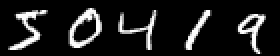

In [29]:
# load mnist
datasetX,    datasetY    = MNIST(:train)[:]
validationX, validationY = MNIST(:test)[:]

display( size(datasetX) )

img  = datasetX[:, :, 1:5]
img2 = permutedims(img, (2, 1, 3))

display(datasetY[1:5]')
mosaicview( Gray.(img2)  ; nrow=1)

In [30]:
# split trainset, testset from dataset
Random.seed!(1)
(trainX, trainY), (testX, testY) = stratifiedobs((datasetX, datasetY), p = 0.7)
size(trainX), size(testX), size(validationX)

((28, 28, 42001), (28, 28, 17999), (28, 28, 10000))

##### Preprocessing


In [31]:
function preprocess(X, y)
    newX = pim.batchImage2DF(X)
    #coerce!(newX)   # no need, all scitypes are Continuous in this example
    new_y = coerce(y, OrderedFactor)
    
    return (newX, new_y)
end

X_tr, y_tr = preprocess(trainX, trainY);

In [32]:
scitype(X_tr)

Table{AbstractVector{Continuous}}

In [33]:
scitype(y_tr)

AbstractVector{OrderedFactor{10}} (alias for AbstractArray{OrderedFactor{10}, 1})

##### Reduce dimensions and standardize

In [34]:
# reduce predictors
PCA = @load PCA pkg=MultivariateStats verbosity=0
reducer = PCA(pratio = 0.9)

# standardize predictors
std = Standardizer()

pipe = @pipeline reducer std
mach = MLJ.machine(pipe, X_tr) |> fit!
X_df = MLJ.transform(mach, X_tr) .|> Float32   # ver o que faz

first(X_df,5)

┌ Info: Training machine(Pipeline307(pca = PCA(maxoutdim = 0, …), …), …).
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/QZctr/src/machines.jl:487


┌ Info: Training machine(PCA(maxoutdim = 0, …), …).
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/QZctr/src/machines.jl:487


┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/QZctr/src/machines.jl:487


,x1,x2,x3,x4,x5,x6,x7,x8
,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32
1,1.02553,0.364737,-0.304525,-0.98564,-1.25582,0.654737,0.517963,2.86921
2,1.26633,-0.2766,-1.84139,0.464359,-0.0501048,0.141543,0.672342,-0.192565
3,1.5935,-0.231705,-1.91622,0.777106,-2.09254,-1.47511,-1.23363,1.16235
4,0.0313314,-0.864217,-0.954639,1.03453,-1.16941,0.83675,2.1645,-0.267772
5,-0.824789,0.471452,0.22298,-0.530035,0.209059,1.48011,-1.07067,0.662547
